# Analyse Results

{
    "precision": 0.7623,
    "recall": 0.7158,
    "f1": 0.6614
}


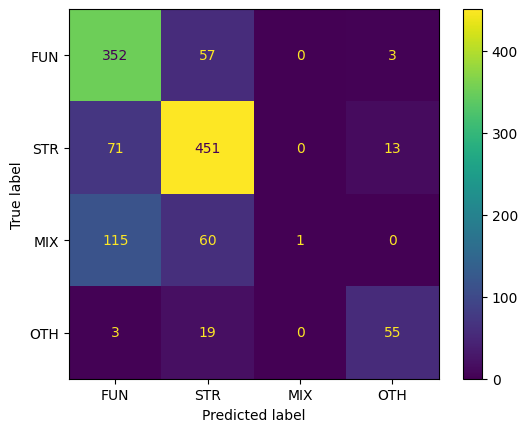

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import ast

# Set file to analyse
file_name = "test_3_3"

# Import data
file_path = f"/home/fantoni/patent-sentence-classification/results/incremental/{file_name}.xlsx"
result_df = pd.read_excel(file_path)

# Set labels
labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = result_df['sent_tag']  
predicted_labels = result_df['predicted_tag']

# Calculate classification metrics
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
results = {
    'precision': round(precision, 4),  # Rounded for better readability
    'recall': round(recall, 4),
    'f1': round(f1, 4)
}
print(json.dumps(results, indent=4))  # Pretty-print the JSON

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

# Compare Incremental

In [104]:
folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

results_all = {}
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        sample_id = file_name.split('_')[1]
        fold = file_name.split('_')[2].replace(".xlsx", "")[-1]
        df = pd.read_excel(os.path.join(folder_path, file_name))

        # Set labels
        labels = ['FUN', 'STR', 'MIX', 'OTH']
        true_labels = df['sent_tag']  
        predicted_labels = df['predicted_tag']

        # Calculate classification metrics
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

        # Ensure sample_id exists in the dictionary
        if sample_id not in results_all:
            results_all[sample_id] = {'precision': [], 'recall': [], 'f1': []}

        # Append results
        results_all[sample_id]['precision'].append(precision)
        results_all[sample_id]['recall'].append(recall)
        results_all[sample_id]['f1'].append(f1)

In [105]:
# Create table for vizualization
table = []
for sample_id, metrics in results_all.items():
    for k in range(len(metrics['precision'])):
        sample_size = id2num[sample_id]
        table.append([sample_size, k+1, round(metrics['precision'][k], 3), round(metrics['recall'][k], 3), round(metrics['f1'][k], 3)])

df = pd.DataFrame(table, columns=['Sample Size', 'Index', 'Precision', 'Recall', 'F1-Score'])
df

In [98]:
# Compute mean of each metric for each sample size
mean_results = {}
for sample_id, metrics in results_all.items():
    mean_results[sample_id] = {metric: round(sum(values) / len(values), 3) if values else 0 for metric, values in metrics.items()}

# Convert mean results to DataFrame
mean_df = pd.DataFrame.from_dict(mean_results, orient='index')
mean_df.index = mean_df.index.map(lambda x: id2num[x])
mean_df.reset_index(inplace=True)
mean_df.rename(columns={'index': 'Sample Size', 'precision': 'Mean Precision', 'recall': 'Mean Recall', 'f1': 'Mean F1-Score'}, inplace=True)
mean_df

,Sample Size,Mean Precision,Mean Recall,Mean F1-Score
0,480,0.539,0.609,0.553
1,960,0.584,0.675,0.621
2,1440,0.719,0.712,0.659
3,1920,0.735,0.741,0.694
4,2400,0.671,0.732,0.679
5,2880,0.686,0.734,0.688
6,3360,0.708,0.744,0.700
7,3840,0.738,0.749,0.708
8,4320,0.742,0.749,0.710


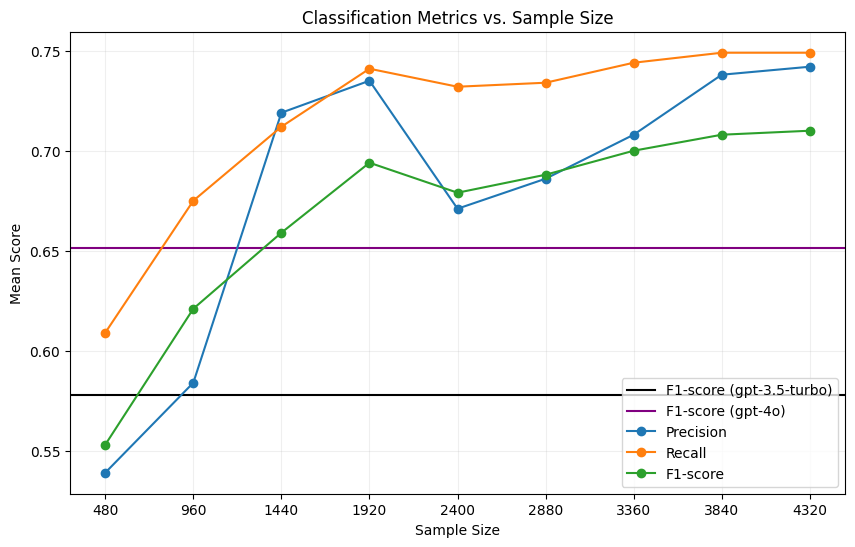

In [99]:
# Extract sample sizes and metrics
sample_sizes = sorted(mean_results.keys())
precision_means = [mean_results[size]['precision'] for size in sample_sizes]
recall_means = [mean_results[size]['recall'] for size in sample_sizes]
f1_means = [mean_results[size]['f1'] for size in sample_sizes]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.axhline(y=0.5776322818165045, color='black',label="F1-score (gpt-3.5-turbo)")  # prompt3
plt.axhline(y=0.6515936410293085, color='purple', label="F1-score (gpt-4o)")  # prompt3

# Convert sample size id to sample size num
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}
sample_sizes_num = [id2num[size] for size in sample_sizes]

plt.plot(sample_sizes_num, precision_means,  marker= 'o', label='Precision')
plt.plot(sample_sizes_num, recall_means, marker= 'o', label='Recall')
plt.plot(sample_sizes_num, f1_means, marker= 'o', label='F1-score')
plt.xticks(sample_sizes_num)
plt.xlabel('Sample Size')
plt.ylabel('Mean Score')
plt.title('Classification Metrics vs. Sample Size')
plt.legend()
plt.grid(True, alpha=0.2)  # Improved grid visibility
plt.show()